In [13]:
import zeus21
from matplotlib import pyplot as plt
import numpy as np
from zeus21 import LIM
import matplotlib as mpl

#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts
plt.rcParams['lines.linewidth'] = 2
colors = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

In [14]:
CosmoParams_input = zeus21.Cosmo_Parameters_Input()
ClassyCosmo = zeus21.runclass(CosmoParams_input)
CosmoParams = zeus21.Cosmo_Parameters(CosmoParams_input, ClassyCosmo) 
AstroParams = zeus21.Astro_Parameters(CosmoParams)
HMFintclass = zeus21.HMF_interpolator(CosmoParams,ClassyCosmo)
ZMIN = 10.0 #down to which z we compute the evolution
CoeffStructure_21 = zeus21.get_T21_coefficients(CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)

In [15]:
bar_SFRD = CoeffStructure_21.SFRDbar2D_II

Nsigmad = 5.0 #how many sigmas we explore
Nds = 100 #how many deltas
deltatab_norm = np.linspace(-Nsigmad,Nsigmad,Nds)
zArray, rArray, mArray, deltaNormArray = np.meshgrid(CoeffStructure_21.zintegral, CoeffStructure_21.Rtabsmoo, HMFintclass.Mhtab, deltatab_norm, indexing = 'ij', sparse = True)

rGreaterArray = np.zeros_like(zArray) + rArray

rGreaterArray[CosmoParams.chiofzint(zArray) + rArray >= CosmoParams.chiofzint(50)] = np.nan
zGreaterArray = CosmoParams.zfofRint(CosmoParams.chiofzint(zArray) + rGreaterArray)
sigmaR = np.zeros((len(CoeffStructure_21.zintegral), len(CoeffStructure_21.Rtabsmoo), 1, 1))
whereNotNans = np.invert(np.isnan(rGreaterArray))
sigmaR[whereNotNans] = HMFintclass.sigmaRintlog((np.log(rGreaterArray)[whereNotNans], zGreaterArray[whereNotNans]))

In [16]:
zid = 0
zid1 = 21
Rid = 10
deltaArray = deltaNormArray * sigmaR
SFRD_deltaR =  np.exp(CoeffStructure_21.gamma_II_index2D [zid,Rid]* deltaArray[zid,Rid,0,:]) #* bar_SFRD[zid,Rid]

SFRD_deltaR1 =  np.exp(CoeffStructure_21.gamma_II_index2D [zid1,Rid]* deltaArray[zid1,Rid,0,:])  #* bar_SFRD[zid1,Rid]

sigmaM = np.zeros((len(CoeffStructure_21.zintegral), len(CoeffStructure_21.Rtabsmoo), len(HMFintclass.Mhtab), 1)) ###HAC: Is this necessary?
sigmaM = HMFintclass.sigmaintlog((np.log(mArray), zGreaterArray))

modSigmaSq = sigmaM**2 - sigmaR**2
indexTooBig = (modSigmaSq <= 0.0)
modSigmaSq[indexTooBig] = np.inf #if sigmaR > sigmaM the halo does not fit in the radius R. Cut the sum
modSigma = np.sqrt(modSigmaSq)

nu0 = CosmoParams.delta_crit_ST / sigmaM
nu0[indexTooBig] = 1.0
modd = CosmoParams.delta_crit_ST - deltaArray
nu = modd / modSigma
C_arb = 1.6
EPS_HMF_corr = C_arb * (nu/nu0) * (sigmaM/modSigma)**2.0 * np.exp(-CosmoParams.a_corr_EPS * (nu**2-nu0**2)/2.0 ) * (1.0 + deltaArray)
integrand_II = EPS_HMF_corr * zeus21.sfrd.SFRD_II_integrand(AstroParams, CosmoParams, HMFintclass, mArray, zGreaterArray, zGreaterArray)


SFRD_II_dR = np.trapz(integrand_II, HMFintclass.logtabMh, axis = 2)[zid,Rid] / bar_SFRD[zid,Rid]
SFRD_II_dR1 = np.trapz(integrand_II, HMFintclass.logtabMh, axis = 2)[zid1,Rid] /bar_SFRD[zid1,Rid]

(-0.4, 0.4)

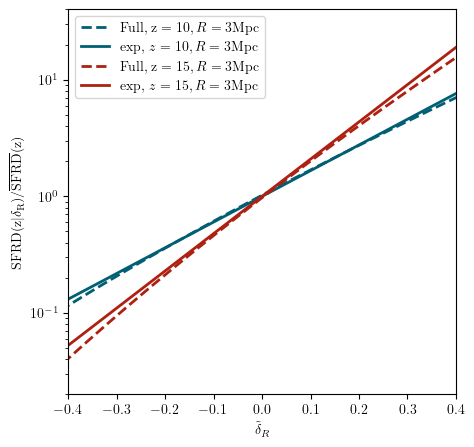

In [27]:
plt.figure(figsize=(5,5))

plt.semilogy(deltaArray[zid,Rid,0,:],SFRD_II_dR,label=r'$\rm Full,\, z=%g$'%round(CoeffStructure_21.zintegral[zid],0) + r'$, R =%g {\rm Mpc}$'%round(CoeffStructure_21.Rtabsmoo[Rid],0),color=colors[1],linestyle='--')
plt.semilogy(deltaArray[zid,Rid,0,:],SFRD_deltaR,label=r'$\exp,\, z=%g$'%round(CoeffStructure_21.zintegral[zid],0) + r'$, R =%g {\rm Mpc}$'%round(CoeffStructure_21.Rtabsmoo[Rid],0),color=colors[1])

plt.semilogy(deltaArray[zid1,Rid,0,:],SFRD_II_dR1,label=r'$\rm Full,\, z=%g$'%round(CoeffStructure_21.zintegral[zid1],0) + r'$, R =%g  {\rm Mpc}$'%round(CoeffStructure_21.Rtabsmoo[Rid],0),color=colors[-2],linestyle='--')

plt.semilogy(deltaArray[zid1,Rid,0,:],SFRD_deltaR1,label=r'$\exp,\, z=%g$'%round(CoeffStructure_21.zintegral[zid1],0) + r'$, R =%g {\rm Mpc}$'%round(CoeffStructure_21.Rtabsmoo[Rid],0),color=colors[-2])
plt.legend()
plt.ylabel(r'$\rm SFRD(z|\delta_R)/\overline{SFRD}(z)$')
plt.xlabel(r'$\tilde{\delta}_R$')
plt.ylim(2e-2,4e1)
plt.xlim(-0.4,0.4)
